In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import seaborn as sns
from tqdm.notebook import tqdm
import vcf
sns.set_style('whitegrid')
sns.set_palette('colorblind')
from collections import Counter

# HIV Long-Haul Mutation Gain-Loss

Consensus sequences and variants were called using 
the FreeBayes-based (v1.3.2 [citation: arXiv:1207.3907]) 
SIGNAL workflow (https://github.com/jaleezyy/covid-19-signal) v1.4.4dev
(#60dd466) [citation: doi.org/10.3390/v12080895] and ncov-tools v1.8.0 
    (https://github.com/jts/ncov-tools). Variant effects were predicted using SnpEff 
    v5.0-0 [citation:10.4161/fly.19695] and the MN908947.3 reference genome. 
    The annotated variant call formats were summarized and the ratio of 
    non-synonymous/synonymous changes per site (Ka/Ks) calculated using PyVCF v0.6.8 [citation:https://github.com/jamescasbon/PyVCF] and pandas v1.2.4. All analysis code is available at: https://github.com/fmaguire/persistent_infection



In [2]:
def parse_vcf_snpeff_record(record, sample):
    parsed_records = []
    for ix, alt in enumerate(record.ALT):
        parsed_alt = {}

        # get var only for that alt
        var_list = [ann for ann in record.INFO['ANN'] if ann.split('|')[0] == alt]
        #remove up/downstream/intergenic mutations
        var_list = [ann for ann in var_list if ann.split('|')[1] not in ['upstream_gene_variant', 
                                                                                 'downstream_gene_variant']]
        if len(var_list) > 1:
            print("var_list has multiple changes", var_list)
            var_list = var_list[0]
        elif len(var_list) == 0:
            print("var_list has no annotation", var_list)
            assert False
        else:
            ann = var_list[0].split('|')
            parsed_alt['Mutation Effect'] = ann[1]
            parsed_alt['Mutation Gene'] = ann[3]
            parsed_alt['Nucleotide Mutation'] = ann[9]
        
            if ann[1] == 'intergenic_region':
                parsed_alt['Protein Mutation'] = f"No Protein Effect ({ann[9]})"
            elif ann[1] == 'synonymous_variant':
                parsed_alt['Protein Mutation'] = ann[3] + ": synonymous " + ann[10]
            else:
                parsed_alt['Protein Mutation'] = ann[3] + ":" + ann[10]

        parsed_alt['Sample'] = sample
        parsed_alt['Genome Position'] = record.POS
        parsed_alt['Allele Read Count'] = record.INFO['AO'][ix]
        parsed_alt['Total Read Count'] = record.INFO['DP']
        parsed_alt['% Reads Supporting Allele'] = record.INFO['VAF'][ix] * 100
    
    parsed_records.append(parsed_alt)
    return parsed_records


parsed_records = []
for vcf_fp in Path('variants/').glob("*.vcf"):
    sample = vcf_fp.name.rstrip('.ann.vcf')
    with open(vcf_fp) as fh:
        for record in vcf.Reader(fh):
            parsed_records.extend(parse_vcf_snpeff_record(record, sample))
            
            
variants = pd.DataFrame(parsed_records)
variants = variants.sort_values(['Sample', 'Genome Position'], ascending=[False, True])
variants['Sample'] = pd.to_datetime(variants['Sample'].str.lstrip('JD-'),dayfirst=True)

# Variant Changes Over Time

In [3]:
variant_sets = variants.groupby('Sample')['Nucleotide Mutation'].agg(Nucleotide_Mutation_Set=set).reset_index()
variant_sets = variant_sets.sort_values('Sample')

previous_mutation_set = set()
variant_set_gain_loss = []
for ix, sample in variant_sets.iterrows():
    
    if len(previous_mutation_set) == 0:
        sample['Mutations Gained'] = set()
        sample['Mutations Lost'] = set()
        previous_mutation_set = sample['Nucleotide_Mutation_Set']
    else:
        sample['Mutations Gained'] = sample['Nucleotide_Mutation_Set'] - previous_mutation_set
        sample['Mutations Lost'] = previous_mutation_set - sample['Nucleotide_Mutation_Set']
        previous_mutation_set = sample['Nucleotide_Mutation_Set']

        
    variant_set_gain_loss.append(sample)  
          
variant_set_gain_loss = pd.DataFrame(variant_set_gain_loss)

variant_set_gain_loss['Mutation Count'] = variant_set_gain_loss['Nucleotide_Mutation_Set'].apply(len)
variant_set_gain_loss['Mutation Gained Count'] = variant_set_gain_loss['Mutations Gained'].apply(len)
variant_set_gain_loss['Mutation Lost Count'] = variant_set_gain_loss['Mutations Lost'].apply(len)

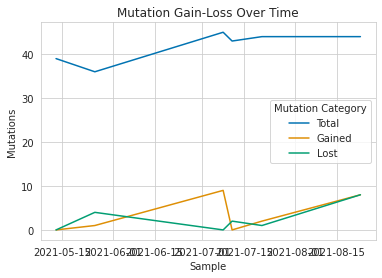

In [4]:
variant_set_melt = pd.melt(variant_set_gain_loss, id_vars=['Sample'], 
                            value_vars=['Mutation Count', 'Mutation Gained Count', 'Mutation Lost Count'],
                            var_name='Mutation Category', value_name='Mutations')
variant_set_melt['Mutation Category'] = variant_set_melt['Mutation Category'].replace({'Mutation Count': 'Total', 
                                                                     'Mutation Gained Count': 'Gained',
                                                                     'Mutation Lost Count': 'Lost'})
sns.lineplot(data = variant_set_melt, x='Sample', y='Mutations', hue='Mutation Category')
plt.title('Mutation Gain-Loss Over Time')
plt.savefig('figures/mutation_gain_loss_counts.png', dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

In [5]:
def plot_allele_pres_absence(variants_subset, title, savepath, all_mutations=False):

    coverage_thresold = 50
    
    variant_order = variants_subset.sort_values("Genome Position")['Protein Mutation'].unique()
    sample_order = variants_subset['Sample'].sort_values().unique()
    variant_presence_absence = pd.crosstab(variants_subset['Sample'], variants_subset['Protein Mutation'])
    variant_presence_absence = variant_presence_absence.loc[sample_order, variant_order].T

    variant_percentage_alleles = variants_subset[variants_subset['Protein Mutation'].isin(variant_presence_absence.index)]
    variant_percentage_alleles = variant_percentage_alleles.pivot('Sample', 'Protein Mutation', '% Reads Supporting Allele').fillna(0)
    variant_order = [x for x in variants_subset.sort_values('Genome Position')['Protein Mutation'].unique() if x in variant_percentage_alleles.columns]
    variant_percentage_alleles = variant_percentage_alleles.loc[sample_order, variant_order].T

    
    # drop any all >99% 
    if not all_mutations:
        all_high_coverage_variants = [var for var in variant_percentage_alleles.T if (variant_percentage_alleles.T[var] > 95).all() ]
        variant_percentage_alleles = variant_percentage_alleles.drop(all_high_coverage_variants)

    # low coverage mutations (possible dropout)
    low_coverage = variants_subset[variants_subset['Allele Read Count'] < coverage_thresold]['Protein Mutation'].unique()
                            
    #variant_percentage_alleles = variant_percentage_alleles.rename(index=possible_dropout)

    #return variant_percentage_alleles
    fig, ax = plt.subplots(figsize=(6,12))
    
    ax.set_title(title)
    sns.heatmap(variant_percentage_alleles, vmin=0, vmax=100, linewidths=.1, ax=ax, xticklabels=True, cmap="mako_r", yticklabels=True,
                cbar_kws={'label': '% Reads Supporting Allele'})
    ax.set_ylabel(f"Protein Mutation\n(Any Sample <{coverage_thresold}X Coverage in Red)")
    ax.set_xlabel(f"Sample Dates")

    # colour OG and low coverage labels
    for label in ax.get_yticklabels():
        if label.get_text() in low_coverage:
            label.set_color('red')
            
     # colour OG and low coverage labels
    for label in ax.get_xticklabels():
        if "OG" in label.get_text():
            label.set_fontweight('bold')
    #return label
    #return fig, ax
    plt.savefig(savepath, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    return variant_percentage_alleles

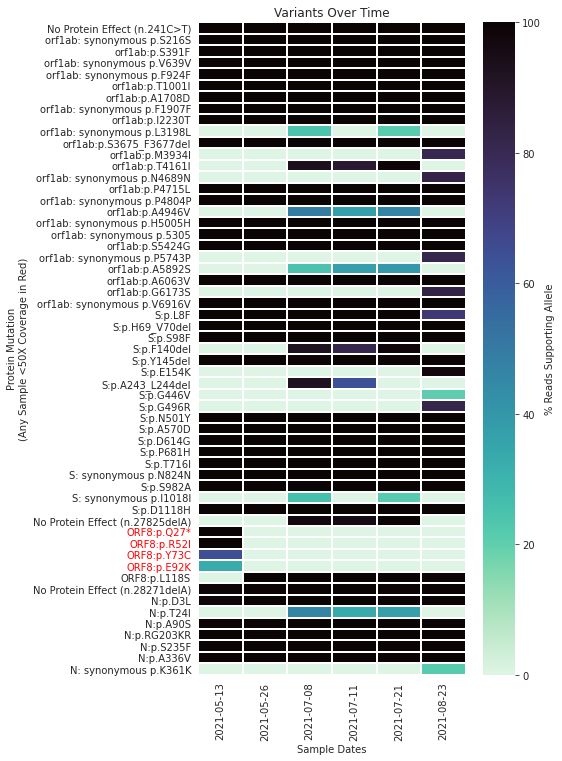

In [6]:
variants['Sample'] = variants['Sample'].dt.strftime("%Y-%m-%d")
variant_percentage_alleles = plot_allele_pres_absence(variants, 'Variants Over Time', "figures/mutation_changes_unique_read_percentage_all.png", all_mutations=True)

In [7]:
variants.to_csv('table/summary_of_variants.tsv', sep='\t', index=False)

# Calculate Ka/Ks

Number of nonsynonymous substitutions per non-synonymous site (Ka), in a given period of time, to the number of synonymous substitutions per synonymous site

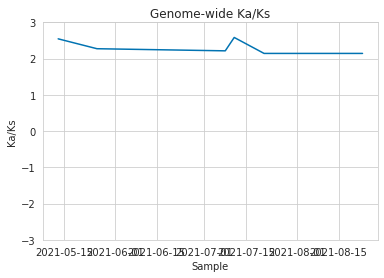

In [8]:
def calculate_ka_ks(variants, fig_name, plot=True):
    variants['Mutation Type'] = variants['Mutation Effect'].replace({'intergenic_region': 'Synonymous Variant',
                                                                     'synonymous_variant': 'Synonymous Variant',
                                                                     'missense_variant': 'Non-Synonymous Variant',
                                                                     'conservative_inframe_deletion': 'Non-Synonymous Variant',
                                                                     'disruptive_inframe_deletion': 'Non-Synonymous Variant',
                                                                      'stop_gained': 'Non-Synonymous Variant'})

    ka_ks = variants.groupby('Sample')['Mutation Type'].value_counts().reset_index(name='Mutations')
    #sns.lineplot(data = ka_ks, y='Mutations', x='Sample Date', hue='Mutation Type')
    ka_ks = ka_ks.pivot('Sample', 'Mutation Type', 'Mutations')
    ka_ks['Ka/Ks'] = ka_ks['Non-Synonymous Variant'] / ka_ks['Synonymous Variant']
    ka_ks = ka_ks.reset_index()
    if plot:
        sns.lineplot(data = ka_ks, x='Sample', y='Ka/Ks')
        plt.ylim(-3,3)
        plt.title('Genome-wide Ka/Ks')
        plt.savefig(fig_name, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    return ka_ks


variants['Sample'] = pd.to_datetime(variants['Sample'], dayfirst=True)

ka_ks = calculate_ka_ks(variants, 'figures/ka_ks_plot.png')
ka_ks.to_csv('table/ka_ks.tsv', sep='\t', index=False)

In [15]:
ka_ks

Mutation Type,Sample,Non-Synonymous Variant,Synonymous Variant,Ka/Ks
0,2021-05-13,28,11,2.545455
1,2021-05-26,25,11,2.272727
2,2021-07-08,31,14,2.214286
3,2021-07-11,31,12,2.583333
4,2021-07-21,30,14,2.142857
5,2021-08-23,30,14,2.142857
